In [1]:
import numpy as np
import itertools
from functools import partial
import networkx as nx
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from ndlib.models import DiffusionModel
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import ndlib.models.dynamic as dm
import ndlib.models.CompositeModel as gc
import ndlib.models.compartments as cp
import dynetx as dn
from pathlib import Path

from typing import Union, List, Dict, Tuple, Optional
from pprint import pprint
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend

no display found. Using non-interactive Agg backend


In [2]:
%matplotlib inline

## Problem 1: Stochastic SIR

Explore the five hallmarks of stochastic SIR dynamics:
 - variability
 - negative co-variances
 - increased transients
 - stochastic resonance
 - and extinctions

Design a set of well chosen experiments to demonstrate all these aspects,also exploring the dependence on the basic parameters in the model.

The first step is creating a stochastic event based SIR model with support for demographic and imports using the **Gillespie’s discrete event model algorithm**.
At each time step, we compute the rates of all possible events, choose the closest one and advance the time.

In [3]:
class SIR_Demographic:
    def __init__(self, beta, gamma, mu=0.0, epsilon=0.0, i0=0.05, N_pop=1000):
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.epsilon = epsilon
        self.i0 = i0
        self.N_pop = N_pop
    
    def simulate(self, t_end=200):
        t = [0]
        I = [int(self.i0 * self.N_pop)]
        S = [self.N_pop - I[0]]
        R = [0]
        
        while t[-1] < float(t_end):
            N = S[-1] + I[-1] + R[-1]
            N = np.max([0.0001, N]) # avoid zero
            events = {
                "birth": self.mu * N,
                "transmission": self.beta * S[-1] * I[-1] / N,
                "recovery": self.gamma * I[-1],
                "death_susceptible": self.mu * S[-1],
                "death_infected": self.mu * I[-1],
                "death_recovered": self.mu * R[-1],
                "import": self.epsilon * S[-1],
            }
            events = {event: rate for event, rate in events.items() if rate > 0}
            if len(events) < 1:
                break
                
            S.append(S[-1])
            I.append(I[-1])
            R.append(R[-1])
            
            # compute arrival times for each
            event_time = {
                event: -1.0/rate * np.log(np.random.uniform(0, 1))
                for event, rate in events.items()
            }
            
            # choose event that will occur next
            event, arrival = sorted(event_time.items(), key=lambda x: x[1])[0]
            
            if event == "birth":
                S[-1] += 1
            elif event == "transmission":
                S[-1] -= 1
                I[-1] += 1
            elif event == "recovery":
                I[-1] -= 1
                R[-1] += 1
            elif event == "death_susceptible":
                S[-1] -= 1
            elif event == "death_infected":
                I[-1] -= 1
            elif event == "death_recovered":
                R[-1] -= 1
            elif event == "import":
                S[-1] -= 1
                I[-1] += 1
            
            t.append(t[-1] + arrival)
        
        t = np.array(t)
        tt = np.linspace(0, t_end, t_end)
        Sip = interp1d(t, np.array(S), fill_value="extrapolate")
        Iip = interp1d(t, np.array(I), fill_value="extrapolate")
        Rip = interp1d(t, np.array(R), fill_value="extrapolate")
        result = np.array([Sip(tt), Iip(tt), Rip(tt)])
        return t, tt, result.T

We also will use a helper function to simulate a SIR experiment with a number of repetitions.

In [4]:
def simulate_sir_demography(
    beta=0.001, gamma=0.01, mu=0.0, epsilon=0.0, i0=0.05,
    N_pop=1000, t_end=200, repetitions=1,
):
    config = dict(
        beta=beta, gamma=gamma, mu=mu, epsilon=epsilon, i0=i0, N_pop=N_pop
    )
    model = SIR_Demographic(**config)
    ts, results = [], []
    for r in range(repetitions):
        _, t, result = model.simulate(t_end)
        ts.append(t)
        results.append(result)
        
    ts = np.vstack(ts).reshape(repetitions, t_end)
    results = np.vstack(results).reshape(repetitions, t_end, 3)
    return ts, results

Finally, we will use helper functions for plotting SIR simulations,
which will take care of computing the mean and std deviation from multiple runs.

In [5]:
def config_str(config, exclude=None):
    config = config or dict()
    exclude = exclude or []
    s = []
    conf = {k:v for k,v in config.items() if k not in exclude}
    handlers = dict(
        beta = lambda v: "$\\beta=$%.2e" % v,
        gamma = lambda v: "$\gamma=$%.2e" % v,
        mu = lambda v: "$\mu=$%.2e" % v,
        epsilon = lambda v: "$\epsilon=$%.2e" % v,
        i0 = lambda v: "$I_0=$%.2e" % v,
        I_0 = lambda v: "$I_0=$%.2e" % v,
        R_0 = lambda v: "$R_0=$%.2f" % v,
        N_pop = lambda v: "$N_{pop}=$%.1e" % v,
    )
    for k, v in conf.items():
        if k in handlers:
            s.append(handlers[k](v))
        else:
            s.append("%s=%.2e" % (k, v))
    return ", ".join(s)

DEFAULT_FONTSIZE = 13

def plot_sir(
    results,
    config,
    savefig=None,
    title=None,
    xlabel=None,
    ylabel=None,
    tightlayout=True,
    figsize=(6,4),
    fontsize=DEFAULT_FONTSIZE,
    confidence=True,
    confidence_scale=1.0,
    confidence_alpha=0.3,
):
    colors = {
        "susceptible": "blue",
        "infected": "red",
        "recovered": "green",
    }
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize)
    
    for label, (t, result, options) in results.items():
        default_options = dict(
            label=label,
            color=colors.get(label.lower(), None),
        )
        options = {**default_options, **options}
        mean = result.mean(axis=0)
        ax.plot(t, mean, **options)
        if confidence and result.shape[0] > 1:
            std = result.std(axis=0)
            ax.fill_between(
                t,
                mean - std*confidence_scale,
                mean + std*confidence_scale,
                alpha=confidence_alpha,
                color=options.get("color"),
            )
    plt.ylabel(ylabel or "population", fontsize=fontsize)
    plt.xlabel(xlabel or "time $t$", fontsize=fontsize)
    plt.title(
        title or "SIR using Gillespie’s discrete event model\n(%s)" % (
            config_str(config)
        ),
        fontsize=fontsize
    )
    plt.legend(fontsize=fontsize)
    if tightlayout:
        plt.tight_layout()
    if savefig:
        Path(savefig).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(savefig, bbox_inches="tight")
    return fig, ax

#### Variability between simulations

It is generally impossible to predetermine the precise disease prevalence at any given point in the future.

This effect is especially pronounced in small populations, which we will show by running the same simulation 10 times on a population of size 40 and plotting the standard deviation for the number of susceptible, infected and recovered over these runs.

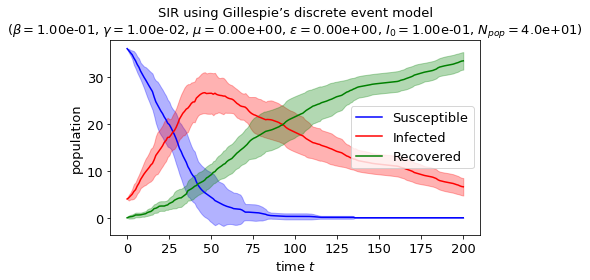

In [6]:
config = dict(
    beta=0.1, gamma=0.01, mu=0.0, epsilon=0.0, i0=0.1, N_pop=40
)
t, results = simulate_sir_demography(repetitions=10, **config)
fig, ax = plot_sir(
    {
        "Susceptible": (t.mean(axis=0), results[:,:,0], {}),
        "Infected": (t.mean(axis=0), results[:,:,1], {}),
        "Recovered":(t.mean(axis=0), results[:,:,2], {}),
    },
    config=config,
    savefig="./fig/a2/sir_demography_stddev.pdf",
)
plt.show()

As hinted before, this effect is pronounced for smaller populations,
where the stochastic nature can lead to very different disease spread trajectories.
We show this by plotting the relative standard deviation of the number of infections 
for different population sizes $N_{pop}$ in the range $[40,500]$.
Here, we use 20 repetitions to reduce the effect of random variation.

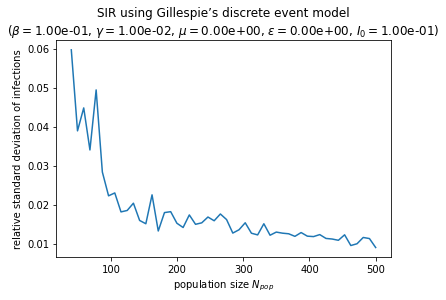

In [7]:
network_sizes = np.linspace(40,500,50)
per_network_size_results = []
for size in network_sizes:
    config = dict(
        beta=0.1, gamma=0.01, mu=0.0, epsilon=0.0, i0=0.1
    )
    t, results = simulate_sir_demography(
        repetitions=20, N_pop=size, **config)
    mean_std = (results[:,:,0] / size).std(axis=0).mean()
    per_network_size_results.append(mean_std)
    
per_network_size_results = np.array(per_network_size_results)
fig, ax = plt.subplots()
ax.plot(network_sizes, per_network_size_results)
plt.ylabel("relative standard deviation of infections")
plt.xlabel("population size $N_{pop}$")
plt.title((
    "SIR using Gillespie’s discrete event model\n(%s)" % config_str(config)
))
plt.show()

Furthermore, infections with low transmission probability $\beta$ generally cause
more variation, because within the same duration, stochasticity of transmission
will lead to very different early infection behaviour. We repeat the same experiment as before for $\beta$ in the range $[0.001,0.5]$ with 20 repetitions.

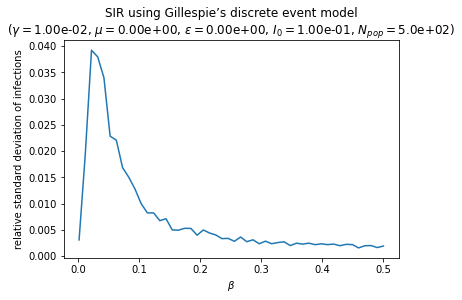

In [8]:
betas = np.linspace(0.001,0.5,50)
per_beta_results = []
for beta in betas:
    config = dict(
        gamma=0.01, mu=0.0, epsilon=0.0, i0=0.1, N_pop=500
    )
    t, results = simulate_sir_demography(
        repetitions=20, beta=beta, **config)
    mean_std = (results[:,:,0] / size).std(axis=0).mean()
    per_beta_results.append(mean_std)
    
per_beta_results = np.array(per_beta_results)
fig, ax = plt.subplots()
ax.plot(betas, per_beta_results)
plt.ylabel("relative standard deviation of infections")
plt.xlabel("$\\beta$")
plt.title((
    "SIR using Gillespie’s discrete event model\n(%s)" % config_str(config)
))
plt.savefig("./fig/a2/sir_demography_relative_stddev_per_beta.pdf")
plt.show()

#### Variances and covariance
- Stochastic processes lead to variance in the prevalence of disease.
- Interaction between stochasticity and underlying deterministic nonlinear dynamics leads to negative covariance between number of susceptibles and infectious.
- And because of that, the mean population level $X,Y$ deviate from the deterministic equilibria.


First, we compute the covariance between the number of infected and 
susceptible for network sizes $N_{pop}$ in the range $[40,500]$ to show that indeed, the covariance is negative for all network size, and even higher for small populations.

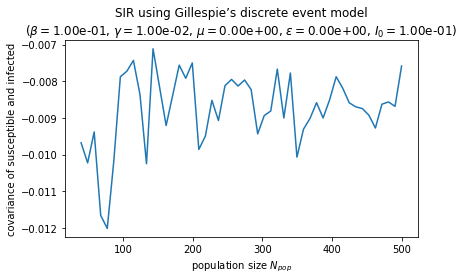

In [9]:
network_sizes = np.linspace(40,500,50)
cov_per_network_size = []
for size in network_sizes:
    config = dict(
        beta=0.1, gamma=0.01, mu=0.0, epsilon=0.0, i0=0.1
    )
    t, results = simulate_sir_demography(repetitions=20, N_pop=size, **config)
    results = np.array(results).mean(axis=0) / size
    cov = np.cov(results[:,0], results[:,1]) # s wrt i
    cov_per_network_size.append(cov)
    
cov_per_network_size = np.array(cov_per_network_size)
fig, ax = plt.subplots()
ax.plot(network_sizes, cov_per_network_size[:,0,1])
plt.ylabel("covariance of susceptible and infected")
plt.xlabel("population size $N_{pop}$")
plt.title((
    "SIR using Gillespie’s discrete event model\n(%s)" % config_str(config)
))
plt.tight_layout()
plt.savefig("./fig/a2/sir_demography_covariance_per_size.pdf")
plt.show()

Now we introduce demography (births and deaths) to the model to show that the mean number of infected individuals deviates from the 
deterministic endemic equilibrium.
Recall that for the deterministic endemic equilibrium, the fraction of infected individuals is given by $I^* = \frac{\mu}{\beta(R_0 - 1.0)}$ with $R_0 = \frac{\beta}{\mu + \gamma}$.

Again, we show this for a small population with $N_{pop} = 100$ and a large population with $N_{pop} = 1000$. We can observe that the deviation from the deterministic equilibrium is again more pronounced for small population sizes.

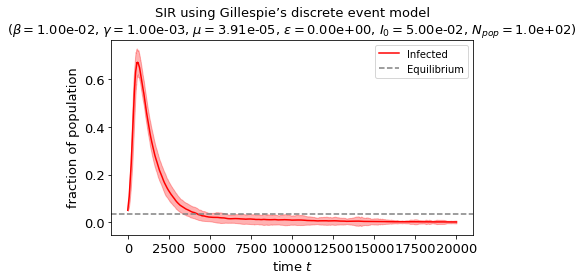

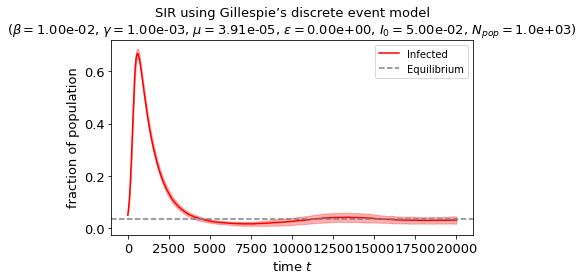

In [10]:
for pop_size in [100, 1000]:
    config = dict(
        beta=0.01, gamma=0.001, mu=1/(70 * 365), epsilon=0.0, i0=0.05,
        N_pop=pop_size
    )
    R_0 = config["beta"] / (config["mu"] + config["gamma"])
    I_equilibrium = config["mu"] / config["beta"] * (R_0 - 1.0)
    t, results = simulate_sir_demography(
        repetitions=100,
        t_end=20_000,
        **config
    )
    fig, ax = plot_sir({
        "Infected": (t.mean(axis=0), results[:,:,1] / pop_size, {})
    }, config=config)
    ax.axhline(y=I_equilibrium, color='gray', label="Equilibrium", linestyle='--')
    plt.ylabel("fraction of population")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./fig/a2/sir_demography_equilibrium_pop{pop_size}.pdf")
    plt.show()

#### Increased transients
- Stochastic perturbations away from the endemic equilibrium are countered by the restorive forces of the endemic attractor, leading to transient like returns to the endemic equilibrium


Now, we will look closer at the dynamics around the determistic endemic equilibrium.
We can clearly see the sharp transient like behaviour when looking at the time range $[7500, 100_000]$. Note that here, a single repetition was used, to avoid canceling out the transient behaviour.

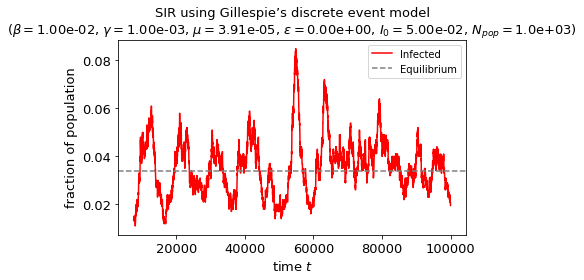

In [11]:
config = dict(
    beta=0.01, gamma=0.001, mu=1/(70 * 365), epsilon=0.0, i0=0.05,
    N_pop=1000
)
R_0 = config["beta"] / (config["mu"] + config["gamma"])
I_equilibrium = config["mu"] / config["beta"] * (R_0 - 1.0)
t, results = simulate_sir_demography(
    repetitions=1, t_end=100_000, **config)
start = 7500
fig, ax = plot_sir({
    "Infected": (
        t.mean(axis=0)[start:],
        results[:,start:,1] / config["N_pop"],
        {},
    )
}, config=config)
ax.axhline(y=I_equilibrium, color='gray', label="Equilibrium", linestyle='--')
plt.ylabel("fraction of population")
plt.legend()
plt.tight_layout()
plt.savefig("./fig/a2/sir_demography_transients.pdf")
plt.show()

#### Stochastic Resonance
- Stochastic perturbations can excite oscillations close to the natural frequency of the deterministic SIR dynamics. So, stochasticity can excite epidemic oscillations around the endemic state.


In [12]:
# TODO

#### Extinctions
- For integer-valued stochastic models, stochasticity can lead to extinctions (that is, the number of infectious individuals goes to zero due to fluctuations), even when $R_0 > 1$.
- In closed populations, chance fluctuations will always in the long run lead to extinction of the disease.
- Long term persistence only possible via import of the pathogen
- Similar extinctions may occur during the early stage of invasion.

We again explore the effect of the population size on the probability of extinctions.
We define the mean time of extinction as the mean fraction of the simulation time steps with a number of infected individuals below $1$.
This is due to the integer nature of infections, where in reality, there must be at least one infected individual.

We chose a disease with $R_0 = 10.0$, which clearly shows that due to the fluctuations, extinctions are still possible in stochastic models.
Note that we also introduce imports into the model, with an import rate of $\epsilon = 0.02\sqrt{N_{pop}}$ to make sure the number of infected individuals will eventually grow above the minimum threshold. The population sizes $N_{pop}$ in the range $[10^2,10^5]$ are considered.

n_pop=100 time_extinct=0.49
n_pop=5357 time_extinct=0.21
n_pop=10615 time_extinct=0.18
n_pop=15873 time_extinct=0.16
n_pop=21131 time_extinct=0.15
n_pop=26389 time_extinct=0.15
n_pop=31647 time_extinct=0.14
n_pop=36905 time_extinct=0.13
n_pop=42163 time_extinct=0.13
n_pop=47421 time_extinct=0.13
n_pop=52678 time_extinct=0.13
n_pop=57936 time_extinct=0.13
n_pop=63194 time_extinct=0.12
n_pop=68452 time_extinct=0.12
n_pop=73710 time_extinct=0.12
n_pop=78968 time_extinct=0.12
n_pop=84226 time_extinct=0.12
n_pop=89484 time_extinct=0.12
n_pop=94742 time_extinct=0.12
n_pop=100000 time_extinct=0.11


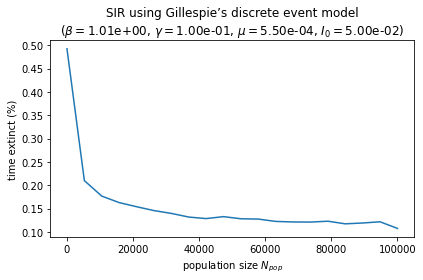

In [13]:
beta = 10 * (5.5*10e-5 + 1/10)
network_sizes = np.linspace(100,100_000,20)
time_extinct_per_population_size = []
config = dict(
    beta=beta, gamma=1/10, mu=5.5*10e-5, i0=0.05,
)
R_0 = config["beta"] / (config["mu"] + config["gamma"])
assert R_0 == 10.0

for N_pop in network_sizes:
    t_end=5 * 365
    t, results = simulate_sir_demography(
        N_pop=size,
        repetitions=50,
        t_end=t_end,
        epsilon=(0.02*np.sqrt(N_pop))/365,
        **config
    )
    extinctions = results[:,:,1] < 1
    mean_extinctions = extinctions.sum(axis=1).mean()
    time_extinct_per_year = (mean_extinctions / (t_end / 365))
    prob_time_extinct_per_year = time_extinct_per_year / 365
    print("n_pop=%d time_extinct=%.2f" % (N_pop, prob_time_extinct_per_year))
    time_extinct_per_population_size.append(prob_time_extinct_per_year)
    
time_extinct_per_population_size = np.array(time_extinct_per_population_size)

fig, ax = plt.subplots()
ax.plot(network_sizes, time_extinct_per_population_size)
plt.ylabel("time extinct (%)")
plt.xlabel("population size $N_{pop}$")
plt.title((
    "SIR using Gillespie’s discrete event model\n(%s)" % config_str(config)
))
plt.savefig("./fig/a2/sir_demography_time_extinct.pdf")
plt.tight_layout()
plt.show()

Diseases with a more variable infectious period have greater variability in the number of secondary cases, and therefore a greater risk of extinction when infectious numbers are low. This leads to the critical community size as a persistence measure for the minimum population size $N_c$ required to avoid extinction.

We define $N_c$ as the population size for which the number of extinctions per year is below 2. To show the dependencies of $N_c$ to $R_0$ and $\gamma$, we iteratively find the critical community size $N_c$ for combinations of $R_0$ in the range $[1, 21]$ and $\gamma$ in the range $[50, 550]$.

In [14]:
%%time
R_0s = np.linspace(1, 21, 6)
gammas = np.linspace(50, 550, 6)
result = np.zeros((len(R_0s), len(gammas)))

for (ri, R_0), (gi, gamma) in itertools.product(enumerate(R_0s), enumerate(gammas)):
    # print("searching", R_0, gamma)
    for pop_size in np.linspace(0.5, 7, 10):
        mu = 0.02/365
        t_end=5 * 365
        beta = R_0 * (mu + 1/gamma)
        config = dict(
            beta=beta, gamma=1/gamma, mu=mu, i0=0.05,
            repetitions=2, t_end=t_end
        )
        epsilon=(0.0213*(R_0-1.0)*np.sqrt(N_pop))/365
        t, results = simulate_sir_demography(
            N_pop=10**pop_size, epsilon=epsilon, **config)
        extinctions = results[:,:,1] < 1
        mean_extinctions = extinctions.sum(axis=1).mean()
        time_extinct_per_year = (mean_extinctions / (t_end / 365))
        # print(time_extinct_per_year)
        if time_extinct_per_year < 2:
            result[ri,gi] = pop_size
            print("found", pop_size, "for", R_0, gamma)
            break
print(result)

found 5.555555555555555 for 1.0 50.0
found 3.388888888888889 for 1.0 150.0
found 3.388888888888889 for 1.0 250.0
found 2.6666666666666665 for 1.0 350.0
found 2.6666666666666665 for 1.0 450.0
found 1.9444444444444444 for 1.0 550.0
found 3.388888888888889 for 5.0 50.0
found 2.6666666666666665 for 5.0 150.0
found 2.6666666666666665 for 5.0 250.0
found 1.9444444444444444 for 5.0 350.0
found 1.9444444444444444 for 5.0 450.0
found 1.9444444444444444 for 5.0 550.0
found 3.388888888888889 for 9.0 50.0
found 3.388888888888889 for 9.0 150.0
found 2.6666666666666665 for 9.0 250.0
found 2.6666666666666665 for 9.0 350.0
found 1.9444444444444444 for 9.0 450.0
found 1.9444444444444444 for 9.0 550.0
found 3.388888888888889 for 13.0 50.0
found 3.388888888888889 for 13.0 150.0
found 2.6666666666666665 for 13.0 250.0
found 2.6666666666666665 for 13.0 350.0
found 1.9444444444444444 for 13.0 450.0
found 1.9444444444444444 for 13.0 550.0
found 3.388888888888889 for 17.0 50.0
found 3.388888888888889 for 17.0

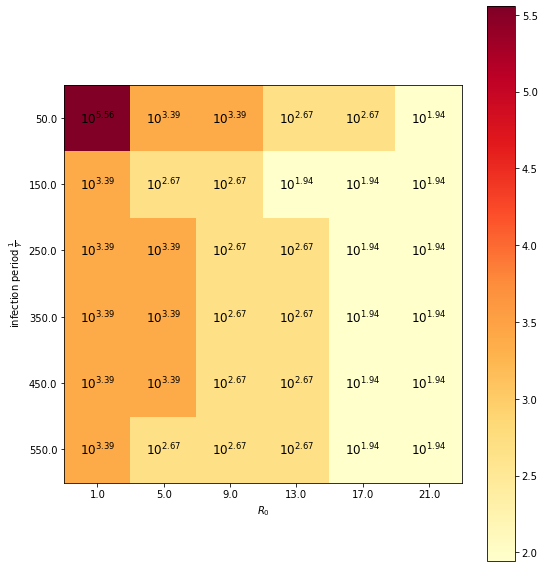

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(result, cmap='YlOrRd')
x, y = np.arange(result.shape[0]), np.arange(result.shape[1])
ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xticklabels(R_0s)
ax.set_yticklabels(gammas)
plt.ylabel("infection period $\\frac{1}{\gamma}$")
plt.xlabel("$R_0$")
plt.colorbar(im)
for ix in x:
    for iy in y:
        text = ax.text(iy, ix, "$10^{%.2f}$" % result[ix, iy],
                       ha="center", va="center", color="black", fontsize="large")

plt.tight_layout()
plt.savefig("./fig/a2/sir_demography_critical_community.pdf")
plt.show()

## Problem 2: Metapopulations

Lets start with implementing a simple meta-population
model to study the spatial dynamics of a spreading infection. Start with a stochastic
meta-population model with two sub-populations. Consider two large, fully susceptible populations, with $\rho_{ii} = 1$ and $\rho_{ij} < 1$. Assume the populations are of the same
size, and ignore demography. What is the effect of the coupling between the two
populations, are there any delays?
Now produce a meta-population of your own using more sub populations (Hint: Try
using different strength of interaction between populations), and comment on the
dynamics.

First, we build a variation of the $\verb|SIR_demography|$ discrete event model, which allows keeping track of multiple metapopulations and takes their interactions into account.

In [16]:
class SIR_Metapopulation:
    def __init__(
        self, beta, gamma, p,
        num_metapopulations=2,
        i0s: Union[List[float], float] = 0.05,
        N_pops: Union[List[int], int] = 1000,
    ):
        self.beta = beta
        self.gamma = gamma
        self.p = p
        self.num_metapopulations = num_metapopulations
        self.i0s = (
            [i0s] * self.num_metapopulations
            if not isinstance(i0s, list) else i0s
        )
        self.N_pops = (
            [N_pops] * self.num_metapopulations
            if not isinstance(N_pops, list) else N_pops
        )
        self.N_pop = np.sum(self.N_pops)
        assert len(self.i0s) == self.num_metapopulations
        assert len(self.N_pops) == self.num_metapopulations
    
    def simulate(self, t_end=200):
        t = [0]
        
        I = [[int(i0 * n_pop)] for i0, n_pop in zip(self.i0s, self.N_pops)]
        S = [[n_pop - Ii[0]] for n_pop, Ii in zip(self.N_pops, I)]
        R = [[0] for _ in self.N_pops]
        
        while t[-1] < float(t_end):
            events = dict()
            infected = np.array([
                I[j][-1] for j in range(self.num_metapopulations)
            ])
            for pop in range(self.num_metapopulations):
                transmission = self.beta * S[pop][-1] * np.sum(
                    self.p[pop] * infected
                ) / self.N_pop
                events[(pop, "transmission")] = transmission
                events[(pop, "recovery")] = self.gamma * I[pop][-1]
            
            events = {event: rate for event, rate in events.items() if rate > 0}
            if len(events) < 1:
                break
            
            for pop in range(self.num_metapopulations):
                S[pop].append(S[pop][-1])
                I[pop].append(I[pop][-1])
                R[pop].append(R[pop][-1])
            
            # compute arrival times for each
            event_time = {
                event: -1.0/rate * np.log(np.random.uniform(0, 1))
                for event, rate in events.items()
            }
            
            # choose event that will occur next
            (pop, event), arrival = sorted(event_time.items(), key=lambda x: x[1])[0]
            
            if event == "transmission":
                S[pop][-1] -= 1
                I[pop][-1] += 1
            elif event == "recovery":
                I[pop][-1] -= 1
                R[pop][-1] += 1
            
            t.append(t[-1] + arrival)
        
        t = np.array(t)
        tt = np.linspace(0, t_end, t_end)
        result = []
        for pop in range(self.num_metapopulations):
            Sip = interp1d(t, np.array(S[pop]), fill_value="extrapolate")
            Iip = interp1d(t, np.array(I[pop]), fill_value="extrapolate")
            Rip = interp1d(t, np.array(R[pop]), fill_value="extrapolate")
            pop_result = np.array([Sip(tt), Iip(tt), Rip(tt)]).T
            result.append(pop_result)
        result = np.array(result)
        return t, tt, result
    
def simulate_sir_metapopulations(
    model, t_end=200, repetitions=2,
):
    results, tt = [], None
    for _ in range(repetitions):
        _, tt, result = model.simulate(t_end)
        results.append(result)
    results = np.array(results)
    return tt, results

First of all, we will use 2 metapopulations with a random interaction matrix $p$ and set a fraction $I_0^1 = 0.1$ to be infected in population 1 and $I_0^2 = 0.0$ in population 2. We expect infected individuals from population 1 to slowly infect susceptible individuals in population 2.

[[1.         0.94120716]
 [0.724674   1.        ]]


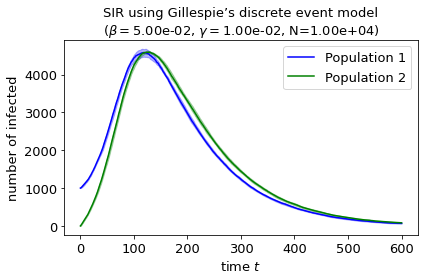

In [17]:
# create random interaction matrix
np.random.seed(42)
p = np.random.uniform(0, 0.99, size=(2,2))
np.fill_diagonal(p, 1)
print(p)

# build metapopulation model
config = dict(
    beta=0.05, gamma=0.01,
)
N = 10_000
num_metapopulations=2
model = SIR_Metapopulation(
    num_metapopulations=num_metapopulations,
    i0s = [0.1, 0.0],
    N_pops = [N, N],
    p = p,
    **config,
)

# run 5 simulations
tt, results = simulate_sir_metapopulations(
    model, t_end=600, repetitions=5,
)
fig, ax = plot_sir({
    "Population 1": (tt, results[:,0,:,1], dict(color="blue")),
    "Population 2": (tt, results[:,1,:,1], dict(color="green")),
}, config={**config, **dict(N=10_000)})
plt.ylabel("number of infected")
plt.tight_layout()
plt.savefig("./fig/a2/sir_meta_delay.pdf")
plt.show()

Now we build a meta-population using more sub populations and a different strength of interaction between populations.
As for the interaction matrices, we will try the following:
- unidirectional
- small interaction
- large interaction

In [52]:
n_metapopulations = 10
interaction_mat_size = (n_metapopulations, n_metapopulations)
top_mask = np.zeros(interaction_mat_size, dtype=bool)
for i,j in itertools.product(range(n_metapopulations), range(n_metapopulations)):
    if i<j:
        top_mask[i,j] = True
# print(top_mask)
# print(top_mask.T)

unidirectional1 = np.random.uniform(0.5, 0.5, size=interaction_mat_size)
unidirectional1[top_mask] = 0.0

unidirectional2 = np.random.uniform(0.5, 0.5, size=interaction_mat_size)
unidirectional2[top_mask.T] = 0.0

np.random.seed(42)
ps = [
    (
        "high bidirectional interaction",
        np.random.uniform(0.75, 0.1, size=interaction_mat_size),
    ),
    (
        "medium bidirectional interaction",
        np.random.uniform(0.5, 0.1, size=interaction_mat_size),
    ),
    (
        "low bidirectional interaction",
        np.random.uniform(0.25, 0.1, size=interaction_mat_size),
    ),
    (
        "unidirectional 1", unidirectional1
    ),
    (
        "unidirectional 2", unidirectional2
    ),
]

[[0.50654892 0.1320357  0.27420394 0.36087199 0.64858788 0.64860356
  0.71224565 0.18698551 0.35927524 0.28975282]
 [0.73662008 0.1195586  0.20891228 0.61197958 0.63181377 0.63078707
  0.55224254 0.40890832 0.46923574 0.56070106]
 [0.35229562 0.65932899 0.56010598 0.5118648  0.45355451 0.23963563
  0.62021204 0.41574762 0.36493053 0.71980723]
 [0.35509585 0.63915932 0.70771646 0.1332244  0.12233918 0.22454172
  0.55200105 0.68651313 0.30524853 0.46390088]
 [0.67067515 0.42813501 0.72764746 0.15894174 0.58179301 0.31936052
  0.5473878  0.41195579 0.39463832 0.6298446 ]
 [0.11976999 0.24616366 0.13932569 0.16836222 0.36136501 0.15078175
  0.69247987 0.62261114 0.72060226 0.53853529]
 [0.49735976 0.57362313 0.21132062 0.51811034 0.56739257 0.39724755
  0.65839925 0.22857196 0.70154208 0.10852349]
 [0.2480409  0.62083481 0.74641062 0.21995007 0.29054273 0.27614534
  0.24867427 0.70187098 0.51699728 0.67468511]
 [0.18898277 0.34485622 0.53491628 0.70868707 0.54786149 0.53863084
  0.27575598

high bidirectional interaction


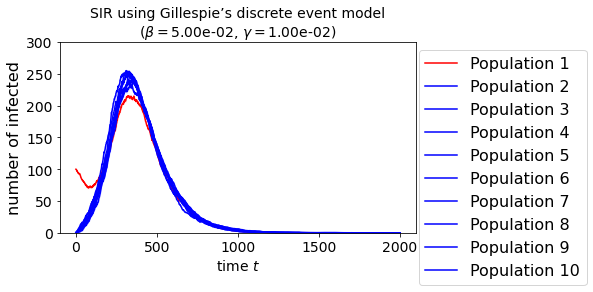

medium bidirectional interaction


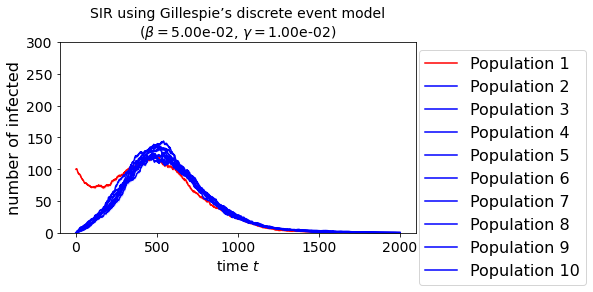

low bidirectional interaction


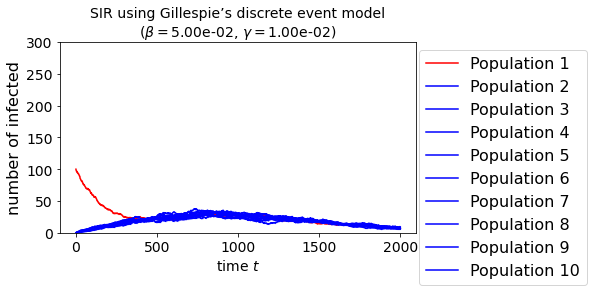

unidirectional 1


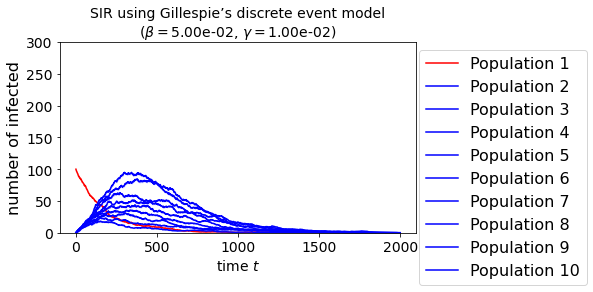

unidirectional 2


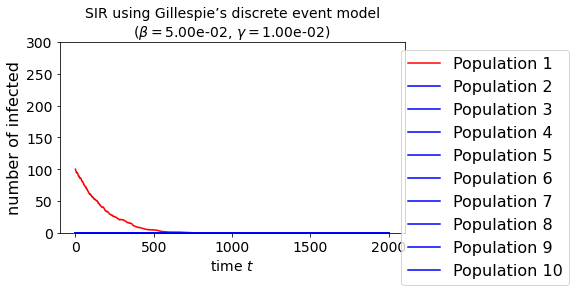

In [57]:
for desc, p in ps:
    p = np.clip(p, 0.0, 0.99)
    np.fill_diagonal(p, 1)
    print(desc)
    config = dict(
        beta=0.05, gamma=0.01,
    )
    model = SIR_Metapopulation(
        num_metapopulations=n_metapopulations,
        i0s = [0.1] + ([0.0] * (n_metapopulations - 1)),
        N_pops = [1_000] * n_metapopulations,
        p = p,
        **config,
    )
    results = []
    for _ in range(5):
        _, tt, result = model.simulate(2000)
        results.append(result)
    results = np.array(results)
    
    fig, ax = plot_sir({
            f"Population {pop+1}": (
                tt, results[:,pop,:,1], dict(color="red" if pop == 0 else "blue")
            ) for pop in range(n_metapopulations)
        },
        config=config,
        fontsize=14,
        confidence_scale=0.1,
        confidence_alpha=0.1
    )
    plt.ylim(0, 300)
    plt.legend(loc='upper right', fontsize=fontsize, bbox_to_anchor=(1.5,1))
    plt.ylabel("number of infected", fontsize=fontsize)
    plt.savefig(f"./fig/a2/sir_meta_{desc}.pdf", bbox_inches="tight")
    plt.show()

## Network model and Vaccines
In this question you are asked to develop a set
of experiments to design and evaluate vaccination strategies using a network model.
Using the package NDLib1 you should assess the spread of a disease (SIR) across different
types of networks (Barabasi Albert, Watts-Strogatz, Erdos-Reyni).

How to assess the impact/spread of the epidemic (what to measure)

- the best way to stop or slow down an epidemic is **early quarantine** and **early vaccination**
- we therefore focus on measuring the **early behavior** of an epidemic

To get started, we build a SIR network model wrapper using the $\verb|ndlib|$ library.

In [20]:
class SIR_Network:
    def __init__(
        self,
        beta = 0.001,
        gamma = 0.01,
    ):
        self.beta = beta
        self.gamma = gamma
    
    def simulate(
        self,
        graph,
        infected: Union[List[int], float] = 0.05,
        susceptible: Union[List[int], float] = None,
        recovered: Union[List[int], float] = None,
        iterations: int = 200,
        repetitions: int = 1,
        custom=False,
    ):
        config = mc.Configuration()
        config.add_model_parameter('beta', self.beta)
        config.add_model_parameter('gamma', self.gamma)
            
        for comp, param in [
            ("Susceptible", susceptible),
            ("Infected", infected),
            ("Removed", recovered),
        ]:
            if isinstance(param, list):
                config.add_model_initial_configuration(comp, param)
            elif isinstance(param, (float, int)):
                config.add_model_parameter(f"fraction_{comp.lower()}", param)
        
        model = ep.SIRModel(graph)
        if custom:
            model = gc.CompositeModel(graph)

            # Model statuses
            model.add_status("Susceptible")
            model.add_status("Infected")
            model.add_status("Recovered")
            model.add_status("Vaccinated")

            # Compartment definition
            s_to_i = cp.NodeStochastic(self.beta, triggering_status="Infected")
            i_to_r = cp.NodeStochastic(self.gamma)

            # Rule definition
            model.add_rule("Susceptible", "Infected", s_to_i)
            model.add_rule("Infected", "Recovered", i_to_r)

        compartments = list(model.available_statuses.values())
        results = np.zeros((repetitions, iterations, len(compartments)))
        
        for r in range(repetitions):
            # simulate
            model.set_initial_status(config)
            simulations = model.iteration_bunch(iterations)
            
            assert len(simulations) == iterations
            for idx, it in enumerate(simulations):
                for compartment, node_count in it["node_count"].items():
                    results[r, idx, compartment] = node_count
        return results

We will also need utily functions to create different kinds of graphs.

In [21]:
def compute_g_c(R_0, g_k, g_k2):
    return 1.0 - (g_k/(g_k2*R_0))

def get_node_deg_asc(g):
    g_node_degrees = (
        g.degree(g.nodes())
        if not nx.is_directed(g) else g.out_degree(g.nodes())
    )
    g_node_degrees = sorted(list(g_node_degrees), key=lambda x: x[1])
    g_k = np.mean([deg for node, deg in g_node_degrees])
    return g_node_degrees, g_k

def random_graph(R_0, n=500, p=0.01):
    # random network, creates new edge with prob p
    g = nx.erdos_renyi_graph(n=n, p=p)
    g_node_degrees, g_k = get_node_deg_asc(g)
    g_k2 = p*(1 - p)*(n-1) + (p**2)*((n-1)**2)
    return g, g_node_degrees, g_k, g_k2, compute_g_c(R_0, g_k, g_k2)
    
def scale_free_graph(R_0, n=500, m=10):
    # Barabási-Albert Model is scale free
    # probability that a new edge is connected with a node is proportional to that nodes
    # degree!
    # degree distribution is power law
    # expresses e.g. the internet, www, email web, citations etc.
    g = nx.barabasi_albert_graph(n=n, m=m)
    g_node_degrees, g_k = get_node_deg_asc(g)
    g_k2 = g_k*(1 + g_k)
    return g, g_node_degrees, g_k, g_k2, compute_g_c(R_0, g_k, g_k2)
    
def small_world_graph(R_0, n=500, m=10, p=0.0):
    # watts strogatz is fully deterministic, everyone connected to its closest neighbours
    # degree distribution is exponential
    g = nx.watts_strogatz_graph(n=network_size, k=n_new_edges, p=p)
    g_node_degrees, g_k = get_node_deg_asc(g)
    g_k2 = g_k*(1 + g_k)
    return g, g_node_degrees, g_k, g_k2, compute_g_c(R_0, g_k, g_k2)

##### How to vary disease initalisation - how many and which nodes to start the infection with?

- Ndlib offers a parameter $\verb|frac_infected|$, which is equivalent to randomly initializing nodes to be infected. For the following experiments, we will fix $I_0 = 0.1 * N_{pop}$ initial infected nodes and use the following strategies to choose the $I_0$ nodes:
1. Choose the $I_0$ nodes with the highest degree, we expect the disease to spread faster due to the high number of neighbors
2. Choose the $I_0$ nodes with the smallest degree, we expect the disease to spread slower or go extinct due to the low number of neighbors
3. Choose $I_0$ nodes randomly, which will be a compromise between 1 and 2 as for large sample sizes the expectation will approximate the mean node degree in the graph. For smaller samples, there can be significant variation.

R_0=1.00
random (Erdos-Renyi)  <k>=5.12  <k2>=29.84  g_c=0.83


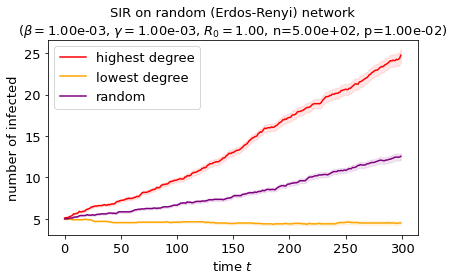

scale-free (Barabási-Albert)  <k>=19.60  <k2>=403.76  g_c=0.95


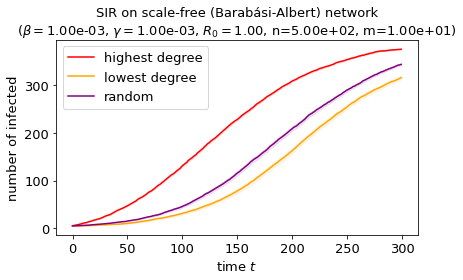

small-world (Watts-Strogatz)  <k>=10.00  <k2>=110.00  g_c=0.91


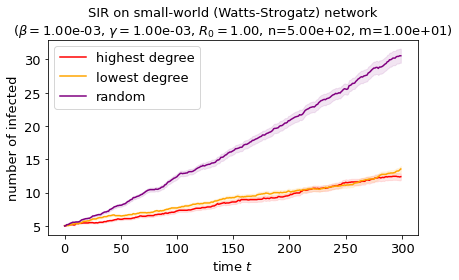

In [59]:
edge_prob = 0.01
network_size = 5_00
n_new_edges = 10
small_world_n_new_edges = 10

I_0_frac = 0.01
I_0 = int(I_0_frac * network_size)

beta = 0.001
gamma = 0.001
R_0 = beta/gamma
print("R_0=%0.2f" % R_0)

config = dict(
    beta = beta, gamma = gamma
)
model = SIR_Network(**config)

iterations=3_00
repetitions=20
fontsize = 13

for graph_type, builder, graph_params in [
    ("random (Erdos-Renyi)", random_graph, dict(R_0=R_0, n=network_size, p=edge_prob)),
    ("scale-free (Barabási-Albert)", scale_free_graph, dict(R_0=R_0, n=network_size, m=n_new_edges)),
    ("small-world (Watts-Strogatz)", small_world_graph, dict(R_0=R_0, n=network_size, m=small_world_n_new_edges)),
]:
    graph, node_degrees_asc, k, k2, g_c = builder(**graph_params)
    print("%s  <k>=%.2f  <k2>=%.2f  g_c=%.2f" % (graph_type, k, k2, g_c))
    model.beta = beta
    model.gamma = gamma
    
    np.random.seed(42)
    strategies = [
        ("highest degree", [n for n, deg in node_degrees_asc[-I_0:]]),
        ("lowest degree", [n for n, deg in node_degrees_asc[:I_0]]),
        ("random", np.random.choice(graph.nodes(), size=I_0, replace=False).tolist()),
    ]
    assert all([len(nodes) == I_0 for _, nodes in strategies])
    
    per_strategy_results = []
    for strategy, infected in strategies:
        nodes = set(graph.nodes())
        susceptible = nodes - set(infected)
        
        results = model.simulate(
            graph,
            infected=infected,
            susceptible=list(susceptible),
            recovered=[],
            iterations=iterations,
            repetitions=repetitions
        )
        per_strategy_results.append(results)
    per_strategy_results = np.array(per_strategy_results)
    
    colors = ["red", "orange", "purple"]
    fig, ax = plot_sir({
            f"{strategy}": (
                np.arange(iterations),
                per_strategy_results[idx,:,:,1],
                dict(color=colors[idx]),
            ) for idx, (strategy, _) in enumerate(strategies)
        },
        fontsize=fontsize,
        config=dict(),
        confidence_scale=0.1,
        confidence_alpha=0.1
    )
    plt.title("SIR on %s network\n(%s)" % (
        graph_type, config_str({**config, **graph_params})
    ), fontsize=fontsize)
    plt.ylabel("number of infected", fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(f"./fig/a2/sir_network_{graph_type}.pdf", bbox_inches="tight")
    plt.show()

##### Vaccine strategy

Design and evaluate a vaccine strategy and test its effectiveness on the different
networks. This vaccine strategy should decide which nodes to vaccinate - you
might consider strategies where you know the network structure OR strategies
where you don’t have global network information (i.e., deliver at random).

R_0=3.00
random (Erdos-Renyi)  <k>=4.90  <k2>=29.84  g_c=0.95
$\beta=$3.00e-03, $\gamma=$1.00e-03, $R_0=$3.00, n=5.00e+02, p=1.00e-02
scale-free (Barabási-Albert)  <k>=19.60  <k2>=403.76  g_c=0.98
$\beta=$3.00e-03, $\gamma=$1.00e-03, $R_0=$3.00, n=5.00e+02, m=1.00e+01
small-world (Watts-Strogatz)  <k>=10.00  <k2>=110.00  g_c=0.97
$\beta=$3.00e-03, $\gamma=$1.00e-03, $R_0=$3.00, n=5.00e+02, m=1.00e+01
CPU times: user 6min 34s, sys: 1.58 s, total: 6min 35s
Wall time: 6min 32s


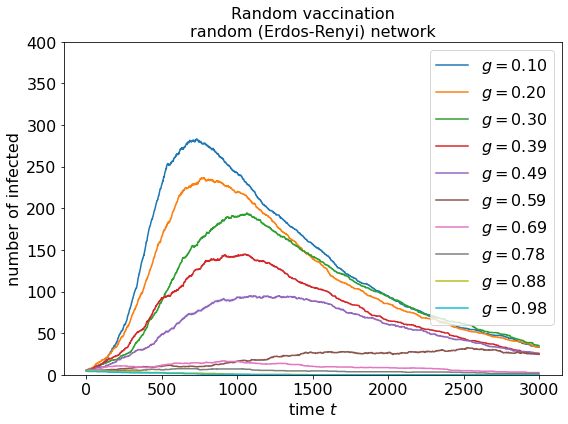

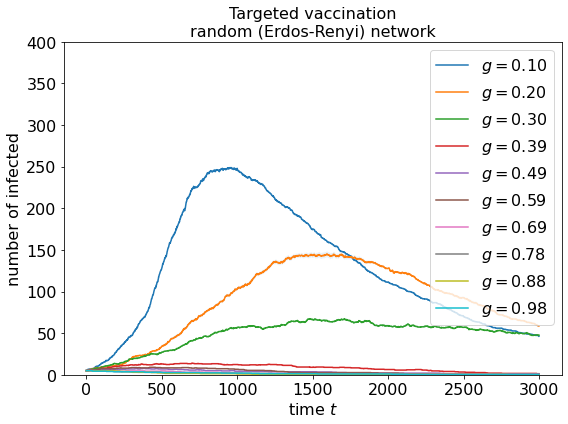

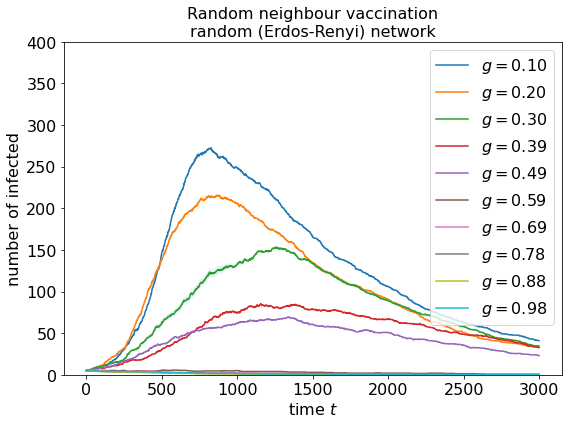

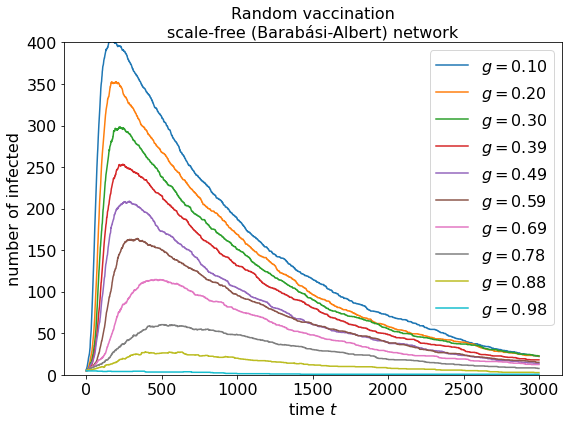

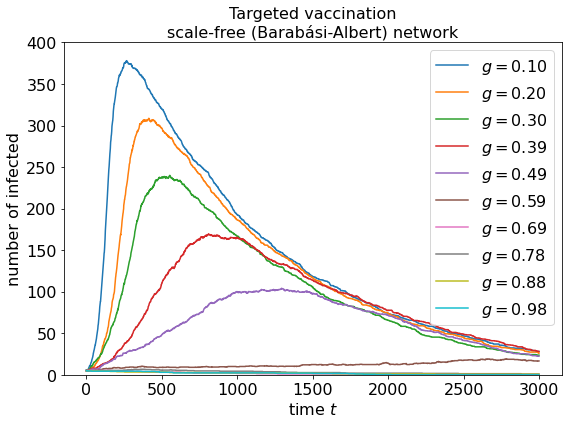

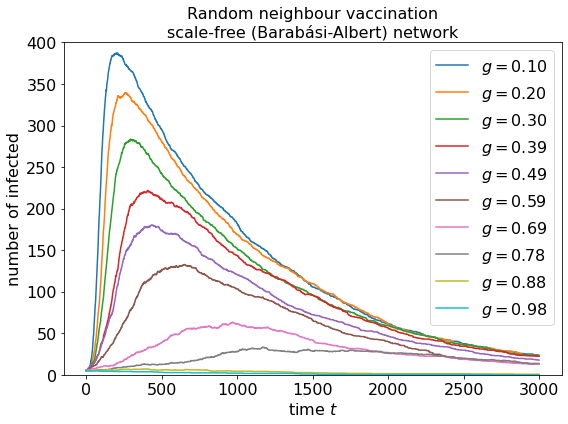

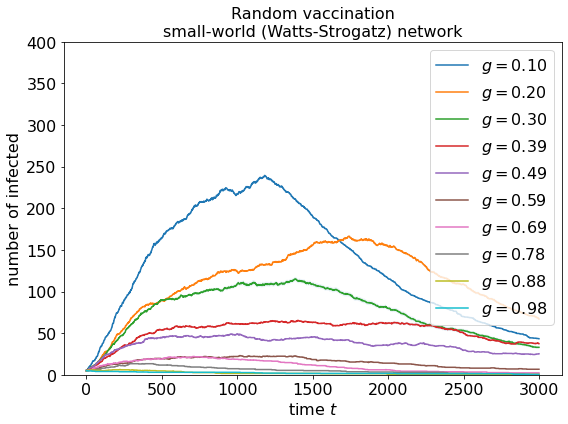

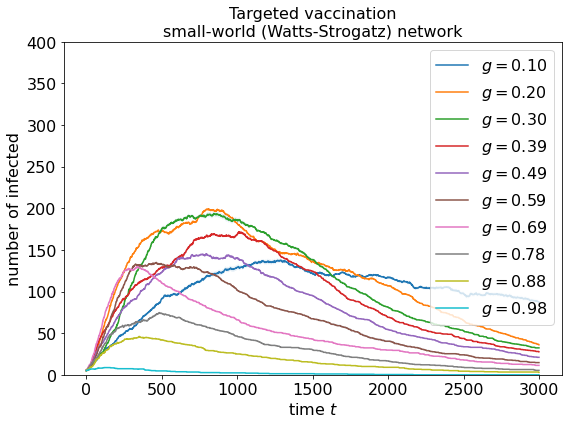

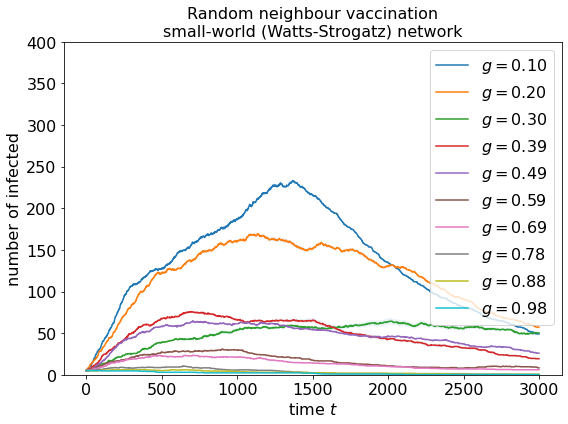

In [43]:
%%time
edge_prob = 0.01
network_size = 500
n_new_edges = 10
small_world_n_new_edges = 10

I_0_frac = 0.01
I_0 = int(I_0_frac * network_size)

beta = 0.003
gamma = 0.001
R_0 = beta/gamma
print("R_0=%0.2f" % R_0)

config = dict(
    beta = beta, gamma = gamma
)
model = SIR_Network(**config)

iterations=3_000
repetitions=3
fontsize = 16
figsize = (8,6)

for graph_type, builder, graph_params in [
    ("random (Erdos-Renyi)", random_graph, dict(R_0=R_0, n=network_size, p=edge_prob)),
    ("scale-free (Barabási-Albert)", scale_free_graph, dict(R_0=R_0, n=network_size, m=n_new_edges)),
    ("small-world (Watts-Strogatz)", small_world_graph, dict(R_0=R_0, n=network_size, m=small_world_n_new_edges)),
]:
    graph, node_degrees_asc, k, k2, g_c = builder(**graph_params)
    print("%s  <k>=%.2f  <k2>=%.2f  g_c=%.2f" % (graph_type, k, k2, g_c))
    print(config_str({**config, **graph_params}))
    model.beta = beta
    model.gamma = gamma
    
    # random vaccination
    per_g_results = []
    gs = np.linspace(0.1, 1.0-2*I_0_frac, 10)
    for g in gs:
        nodes = set(graph.nodes())
        infected = set(np.random.choice(list(nodes), size=I_0, replace=False))
        susceptible = nodes - infected
        recovered = set(np.random.choice(
            list(susceptible), size=int(g * network_size), replace=False))
        susceptible = susceptible - recovered
        assert len(susceptible.union(infected).union(recovered)) == len(nodes)

        results = model.simulate(
            graph,
            susceptible=list(susceptible),
            infected=list(infected),
            recovered=list(recovered),
            iterations=iterations,
            repetitions=repetitions
        )
        per_g_results.append(results)
    
    per_g_results = np.array(per_g_results)
    fig, ax = plot_sir({
            "$g=%.2f$" % g: (
                np.arange(iterations),
                per_g_results[idx,:,:,1],
                dict(),
            ) for idx, g in enumerate(gs)
        },
        title="Random vaccination\n%s network" % (
            graph_type
        ),
        figsize=figsize,
        fontsize=fontsize,
        config=dict(),
        confidence_scale=0.1,
        confidence_alpha=0.1
    )
    plt.ylabel("number of infected", fontsize=fontsize)
    plt.legend(loc='upper right', fontsize=fontsize)
    plt.ylim(0, 400)
    plt.tight_layout()
    plt.savefig(f"./fig/a2/sir_network_{graph_type}_random_vac.pdf",
        bbox_inches="tight")
    
    # targeted vaccination
    per_g_results = []
    gs = np.linspace(0.1, 1.0-2*I_0_frac, 10)
    for g in gs:
        nodes = set(graph.nodes())
        
        recovered = set([n for n, deg in node_degrees_asc[-int(g * network_size):]])
        susceptible = nodes - recovered
        infected = set(np.random.choice(list(susceptible), size=I_0, replace=False))
        susceptible = susceptible - infected
        assert len(susceptible.union(infected).union(recovered)) == len(nodes)

        results = model.simulate(
            graph,
            susceptible=list(susceptible),
            infected=list(infected),
            recovered=list(recovered),
            iterations=iterations,
            repetitions=repetitions
        )
        per_g_results.append(results)
        
    per_g_results = np.array(per_g_results)
    fig, ax = plot_sir({
            "$g=%.2f$" % g: (
                np.arange(iterations),
                per_g_results[idx,:,:,1],
                dict(),
            ) for idx, g in enumerate(gs)
        },
        title="Targeted vaccination\n%s network" % (
            graph_type
        ),
        figsize=figsize,
        fontsize=fontsize,
        config=dict(),
        confidence_scale=0.1,
        confidence_alpha=0.1
    )
    plt.ylabel("number of infected", fontsize=fontsize)
    plt.legend(loc='upper right', fontsize=fontsize)
    plt.ylim(0, 400)
    plt.tight_layout()
    plt.savefig(f"./fig/a2/sir_network_{graph_type}_target_vac.pdf",
        bbox_inches="tight")
    
    # random neighbour vaccination
    per_g_results = []
    gs = np.linspace(0.1, 1.0-2*I_0_frac, 10)
    for g in gs:
        nodes = set(graph.nodes())
        
        # Select a random individual, then immunize one of its RANDOMLY CHOSEN FRIENDs.
        # If you follow an edge, you are likely to meet high-degree nodes!
        nodes_with_neighbours = [
            n for n, deg in node_degrees_asc if deg > 0
        ]
        assert len(nodes_with_neighbours) > int(g * network_size)
        
        recovered = set()
        while len(recovered) < int(g * network_size):
            # choose random neigbour node
            node = np.random.choice(nodes_with_neighbours, size=1)[0]
            neighbour = np.random.choice(list(graph.neighbors(node)), size=1)[0]
            recovered.add(neighbour) # no duplicates
            
        assert len(recovered) == int(g * network_size)
        susceptible = nodes - recovered
        infected = set(np.random.choice(list(susceptible), size=I_0, replace=False))
        susceptible = susceptible - infected
        assert len(susceptible.union(infected).union(recovered)) == len(nodes)

        results = model.simulate(
            graph,
            susceptible=list(susceptible),
            infected=list(infected),
            recovered=list(recovered),
            iterations=iterations,
            repetitions=repetitions
        )
        per_g_results.append(results)
        
    per_g_results = np.array(per_g_results)
    fig, ax = plot_sir({
            "$g=%.2f$" % g: (
                np.arange(iterations),
                per_g_results[idx,:,:,1],
                dict(),
            ) for idx, g in enumerate(gs)
        },
        title="Random neighbour vaccination\n%s network" % (
            graph_type
        ),
        figsize=figsize,
        fontsize=fontsize,
        config=dict(),
        confidence_scale=0.1,
        confidence_alpha=0.1
    ) 
    plt.ylabel("number of infected", fontsize=fontsize)
    plt.legend(loc='upper right', fontsize=fontsize)
    plt.ylim(0, 400)
    plt.tight_layout()
    plt.savefig(
        f"./fig/a2/sir_network_{graph_type}_random_neighbour_vac.pdf",
        bbox_inches="tight")